In [38]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
from tqdm import tqdm
from torch import optim

import logging
from torch.utils.tensorboard import SummaryWriter

device_id = 0
device = torch.device(f'cuda:{device_id}' if torch.cuda.is_available() else 'cpu')
print(f'device is {device}')

device is cpu


In [4]:
logging.basicConfig(format="%(asctime)s - %(levelname)s: %(message)s", level=logging.INFO, datefmt="%I:%M:%S")

## Models

In [ ]:
# Helper blocks

class DoubleConv(nn.Module):
  def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
    """Normal convolution block consisting of 2d convolution, group norm, gelu() activation
      We can also add a residual connection if desired.
    """
    super().__init__()
    self.residual = residual
    if not mid_channels:
      mid_channels = out_channels
    self.double_conv = nn.Sequential(
        nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
        nn.GroupNorm(1, mid_channels),
        nn.GELU(),
        nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
        nn.GroupNorm(1, out_channels),
    )

  def forward(self, x):
    if self.residual:
      return F.gelu(x + self.double_conv(x))
    else:
      return self.double_conv(x)

class Down(nn.Module)
  def __init__(self, in_channels, out_channels, emb_dim=256):
    """Reduce the size by half with max pool. 
        We encode time steps to certain dimension, and use a linear projection to bring
        the time embedding to proper dimension.
    """
    super().__init__()
    self.maxpool_conv = nn.Sequential(
        nn.MaxPool2d(2),
        DoubleConv(in_channels, in_channels, residual=True),
        DoubleConv(in_channels, out_channels),
    )

    self.emb_layer = nn.Sequential(
        nn.SiLU(),
        nn.Linear(
            emb_dim, out_channels
        ),
    )

  def forward(self, x, t):
    x = self.maxpool_conv(x)
    emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
    return x + emb 

class Up(nn.Module):
  def __init__(self, in_channels, out_channels, emb_dim=256):
    """Use an upsample operation. Also take in skip connection from encoder,
      after upsampling normal x, concatenate it with the skip connection and
      feed through convolutional block, adding the time embedding again.
    """
    super().__init__():    
    
    self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
    self.conv = nn.Sequential(
        DoubleConv(in_channels, in_channels, residual=True),
        DoubleConv(in_channels, out_channels, in_channels // 2),
    )

    self.emb_layer = nn.Sequential(
        nn.SiLU(),
        nn.Linear(
            emb_dim, out_channels
        ),
    )

  def forward(self, x, skip_x, t):
    x = self.up(x)
    x = torch.cat([skip_x, x], dim=1)
    x = self.conv(x)
    emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
    return x + emb
    
class SelfAttention(nn.Module):
  def __init__(self, channels, size):
    """Regular attention block."""
    super(SelfAttention, self).__init__()
    self.channels = channels
    self.size = size
    self.mha = nn.MultiheadAttention(channels, 4, batch_first=True)
    self.ln = nn.LayerNorm([channels])
    self.ff_self = nn.Sequential(
        nn.LauerNorm([channels]),
        nn.Linear(channels, channels),
        nn.GELU(),
        nn.Linear(channels, channels),
    )

  def forward(self, x):
    """Prelayer norm, followed by mha, then add skip connection"""

    # Bring channel axis into last dimension for attention to work
    x = x.view(-1, self.channels, self.size * self.size).swapaxes(1, 2)
    x_ln = self.ln(x)
    attention_value, _ = self.mha(x_ln, x_ln, x_ln)
    attention_value = attention_value + x
    attention_value = self.ff_self(attention_value) + attention_value
    return attention_value.swapaxes(2, 1).view(-1, self.channels, self.size, self.size)


In [37]:
# Define UNet
# Has an encoder, bottleneck, and decoder

class UNet(nn.Module):
  def __init__(self, c_in=3, c_out=3, time_dim=256, device=device):
    super().__init__()
    self.device = device
    self.time_dim = time_dim
    
    # Encoder
    self.inc = DoubleConv(c_in, 64)
    self.down1 = Down(64, 128)
    self.sa1 = SelfAttention(128, 32)

    self.down2 = Down(128, 256)
    self.sa2 = SelfAttention(256, 16)

    self.down3 = Down(256, 256)
    self.sa3 = SelfAttention(256, 8)

    # Bottleneck
    self.bot1 = DoubleConv(256, 512)
    self.bot2 = DoubleConv(512, 512)
    self.bot3 = DoubleConv(512, 256)

    # Decoder
    self.up1 = Up(512, 128)
    self.sa4 = SelfAttention(128, 16)

    self.up2 = Up(256, 64)
    self.sa5 = SelfAttention(64, 32)

    self.up3 = Up(128, 64)
    self.sa6 = SelfAttention(64, 64)

    # Project back to output channel dimension
    self.outc = nn.Conv2d(64, c_out, kernel_size=1)

  def pos_encoding(self, t, channels):
    """Encode time tensor using sinusoidal embedding"""
    inv_freq = 1.0 / (
        10000
        ** (torch.arange(0, channels, 2, device=self.device).float() / channels)
    )
    pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
    pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
    pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
    return pos_enc

  def forward(self, x, t):
    """Take as input the noise images and the timesteps.
      Instead of passing these timesteps to the model directly, 
      encode them first.
      Use sinusoidal embedding."""

    t = t.unsqueeze(-1).type(torch.float)
    t = self.pos_encoding(t, self.time_dim)

    # Encoder (downsampling)
    x1 = self.inc1(x)
    x2 = self.down1(x1, t)
    x2 = self.sa1(x2)

    x3 = self.down2(x2, t)
    x3 = self.sa2(x3)

    x4 = self.down3(x3, t)
    x4 = self.sa3(x4)

    # Bottleneck
    x4 = self.bot1(x4)
    x4 = self.bot2(x4)
    x4 = self.bot3(x4)

    # Decoder (upsampling)
    x = self.up1(x4, x3, t)
    x = self.sa4(x)

    x = self.up2(x, x2, t)
    x = self.sa5(x)

    x = self.up3(x, x1, t)
    x = self.sa6(x)

    output = self.outc(x)
    return output


In [3]:
class Diffusion:
  def __init__(self, noise_steps=1000, beta_start=1e-4, beta_end=0.02, img_size=64, device=device):
    self.noise_steps = noise_steps
    self.beta_start = beta_start
    self.beta_end = beta_end
    self.img_size = img_size
    self.device = device

    self.beta = self.prepate_noise_schedule().to(device)
    self.alpha = 1. - self.beta
    self.alpha_hat = torch.cumprod(self.alpha, dim=0)

  def prepare_noise_scheduler(self):
    return torch.linspace(self.beta_start, self.beta_end, self.noise_steps)

  def noise_images(self, x, t):
    sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
    sqrt_one_minus_alpha_hat = torch.sqrt(1. - self.alpha_hat[t])[:, None, None, None]
    eps = torch.randn_like(x) # random noise
    return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * eps, eps

  def sample_timesteps(self, n):
    return torch.randint(low=1, high=self.noise_steps, size=(n,))

  def sample(self, model, n):

    model.eval()
    with torch.no_grad():

      # Create initial images by sampling from the Normal distribution
      x = torch.randn((n, 3, self.img_size, self.img_size)).to(self.device)

      # Go through all noise steps in reverse order 
      for i in tqdm(reversed(range(1, self.noise_steps)), position=0):

        # Create a tensor of length n to create the timesteps
        t = (torch.ones(n) * i).long().to(self.device)
        predicted_noise = model(x, t)
        alpha = self.alpha[t][:, None, None, None]
        alpha_hat = self.alpha_hat[t][:, None, None, None]
        beta = self.beta[t][:, None, None, None]

        # We don't want to add noise in the last iteration
        if i > 1:
          noise = torch.randn_like(x)
        else:
          noise = torch.zeros_like(x)

        # Finally, alter the images with a little bit of noise according to Alg 2
        x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) +\
              torch.sqrt(beta) * noise

    model.train()
    x = (x.clamp(-1, 1) + 1) / 2
    x = (x * 255).type(torch.uint8)
    return x

## Train

In [ ]:
class Train():
  def __init__(self, model, diffusion, dataloader, lr, run_name)
    """Training class"""
    self.model = model
    self.diffusion = diffusion
    self.dataloader = dataloader
    self.run_name = run_name

    self.optimizer = optim.AdamW(self.model.parameters(), lr=lr)
    self.mse = nn.MSELoss()

    l = len(dataloader)

  def train(self, epochs):
    for epoch in range(epochs):
      pbar = tqdm(self.dataloader)
      
      for i, (images, _) in enumerate(pbar):
        images = images.to(device)
        t = self.diffusion.sample_timesteps(images.shape[0]).to(device)
        x_t, noise = self.diffusion.noise_images(images, t)
        predicted_noise = self.model(x_t, t)
        loss = self.mse(noise, predicted_noise)

        # Backprop
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        pbar.set_postfix(MSE=loss.item())

      sampled_images = self.diffusion.sample(self.model, n=images.shape[0])
      save_images(sampled_images, os.path.join("results", self.run_name, f'{epoch}.jpg'))
      torch.save(self.model.state_dict(), os.path.join("models", self.run_name, f'ckpt.pt')




In [34]:
t = (torch.ones(2) * 1).long()
print(t, t.shape)

tensor([1, 1]) torch.Size([2])


In [35]:
beta = torch.linspace(1e-4, 0.02, 1000)
alpha = 1. - beta
print(alpha.shape)
alpha_hat = torch.cumprod(alpha, dim=0)
print(alpha_hat.shape)

torch.Size([1000])
torch.Size([1000])


In [36]:
test1 = torch.sqrt(alpha_hat[t])[:, None, None, None]
print(test1, test1.shape)

tensor([[[[0.9999]]],


        [[[0.9999]]]]) torch.Size([2, 1, 1, 1])


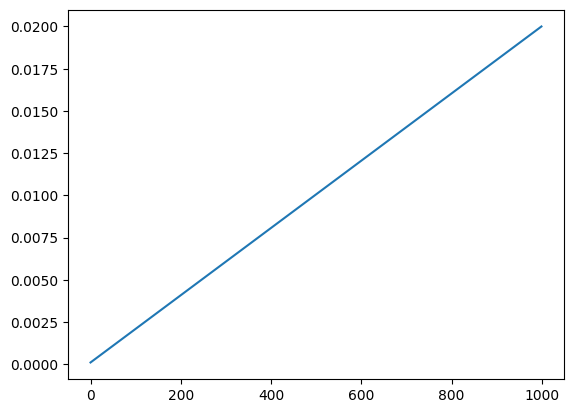

In [14]:
plt.plot(test)